# 40 Practices on Stock Data Processing

## Load Packages

In [134]:
library(data.table)  # the best data manipulation package
library(stringr)  # process strings
library(magrittr)  # pipe operator, e.g., "%>%"
library(lubridate)  # for date and time processing

````{admonition} About the Code Comments
For instruction purpose, I tried to provide as many comments as possible, which may render the code unnecessarily long and scary. For example (Question 6):

```{code-block} python
data[
    # filter stocks
    retx>=0.05 | retx<=-0.05,
    ][, 
    # create `direction` to indicate price change direction
    ':='(direction=ifelse(retx>=0.05, 'up5%+', 'down5%-'))
    ][, 
    # count the stocks
    .(num_stk=uniqueN(permno)),
    keyby=.(date, direction)
    ][1:5]
```

However, if you take out the comments and rearrange the code, it'll be much more friendly:

```{code-block} python
data[retx>=0.05 | retx<=-0.05,
    ][, ':='(direction=ifelse(retx>=0.05, 'up5%+', 'down5%-'))
    ][, .(num_stk=uniqueN(permno)),
    keyby=.(date, direction)
    ][1:5]
```

````

## Inspect the Data

We select the price and trading data of all US common stocks from the CRSP database between 2023-01-01 and 2023-06-30. Each row represents a stock's daily observation. There're in total 4221 unique stocks with about 465k rows.

```{admonition} Observation vs. Row
In my book, I use "observation" and "row" interchangeably, which is common in the field of data science.

As a related note, "field," "column," "variable," and "feature" are also interchangeably to indicate a column of a table. While statisticians prefer "variable", data scientists use "feature" more often. "Field" and "column" are often seen in the context of database.
```

In [135]:
# read data
data = readRDS("data/crsp.rds")

# convert to data.table
setDT(data)  

# print the first 3 rows
data[1:3]

permno date       ticker open  high  low   close cap      dlyfacprc vol   
1 11790  2023-01-03 ALCO   23.91 24.02 23.42 23.83 180941.2 1         115286
2 11790  2023-01-04 ALCO   23.81 24.37 23.68 23.99 182156.1 1          46646
3 11790  2023-01-05 ALCO   23.75 24.06 23.53 23.79 180637.5 1          61673
  prcvol  retx         industry                                   is_sp500
1 2747265 -0.001675744 Agriculture, Forestry, Fishing and Hunting FALSE   
2 1119038  0.006714226 Agriculture, Forestry, Fishing and Hunting FALSE   
3 1467201 -0.008336807 Agriculture, Forestry, Fishing and Hunting FALSE

- This is "panel datak," meaning it contains multiple stocks (cross-sectional) with each stock has multiple observations ordered by date (time-series).

- Each combination of `permno` (stock ID) and `date` determines a unique observation, i.e., they're the key.

- The dataset is first sorted by `permno`, and then `date`

- Column definition:

    - `permno`: The unique ID provided by CRSP.
    - `date`: Date
    - `ticker`: Ticker. Note that the ticker of a stock can change, and hence it's not recommended to use `ticker` as stock ID.
    - `industry`: The industry classification determined using the first two digits of NAICS industry classification code. See the [official document](https://www.census.gov/naics/?58967?yearbck=2022) for more details.
    - `is_sp500`: `TRUE` if the stock is in the S&P 500 list by the mid 2023; `FALSE` if not.
    - `open`: Daily open
    - `high`: Daily high
    - `low`: Daily low
    - `cap`: Daily market capital (in $1000)
    - `dlyfacprc`: Daily factor to adjust for price. (We won't use it in the practice.)
    - `vol`: Trading volume **(number of shares traded)**
    - `prcvol`: **Dollar** trading volume, calculated as the number of shares traded multiplied by the price per share.
    - `retx`: Daily return (excluding dividend).

```{warning}
Without specifying otherwise, we mean `prcvol` (dollar trading volume) whenever we say trading volume. The reason is simple: only dollar trading volume are comparable across different stocks.
```

## Find out all stocks whose ticker contains `"COM"`

We use the `str_detect` function (from the `stringr` package) to find out all ticksers that have a `"COM"`. But that's only half the way. Without deduplicating (the `unique()` function), we will end up with numerous duplicate observations whose `permno` and `ticker` are the same but only differ in `date.`

We provide no arguments to `unique()`, meaning R needs to consider all columns.

In [136]:
data[str_detect(ticker, 'COM'), .(permno, ticker)
    ] %>% unique()

permno ticker
1 77178  QCOM  
2 20421  COMS  
3 14239  COMM  
4 19136  MCOM  
5 92716  DCOM  
6 20916  COMP

**Execution explained:**

- First, R executes `str_detect(ticker, 'COM')` to filter out the needed rows.
- Then, it only keeps two columns, `.(permno, ticker)`. By then, we have many duplicates.
- Lastly, we use `unique()` to remove the duplicates.

## How many stocks on each day have positive/negative returns?

Since we want to count the stocks *on each day*, We need to first group all stocks by `date` and then by the return sign (positive vs. negative). Next, we need to generate two counts: one for the up (positive return) and the other for the down (negative). We leverage the `sign` of `retx` (return) to determine the direction of price change.

In [137]:
# step 1: create a new column "direction" which indicates the direction of the price change
data_q2 = data[, ':='(direction = sign(retx))]
data_q2 = data_q2[!is.na(direction)]

# step 2: count the stocks with +/- returns on each day
data_q2[, .(num=uniqueN(permno)), keyby=.(date, direction)][1:5]

date       direction num 
1 2023-01-03 -1        1843
2 2023-01-03  0          97
3 2023-01-03  1        1834
4 2023-01-04 -1         993
5 2023-01-04  0         103

**Output Explained:**

- On each day we have three observations (rows), one for each direction (1, 0, and -1) of the price change. For example, on 2023-01-03, there're 1844 stocks with positive return.

**Execution Explained:**

- In Step 1, we create a new column `direction` to indicate whether we're counting the up/down/no-move stocks for each day. Its value is 1, 0, or -1, depending on the sign of `retx`.

- In Step 2, I group all observations by `date` (since we want statistics for each day) and then `direction`. `uniqueN()` is used to count the unique stock IDs within each group.

However, we don't need to split the code explicitly. One great thing about `data.table` is that it can chain multiple computation steps together using `[`. In the following code, I put the creation of `direction` in the `key` argument.

In [138]:
# chain the two steps together (same results)
data[, .(num=uniqueN(permno)),
    keyby=.(date, direction=sign(retx))
    ][!is.na(direction)][1:5]

date       direction num 
1 2023-01-03 -1        1843
2 2023-01-03  0          97
3 2023-01-03  1        1834
4 2023-01-04 -1         993
5 2023-01-04  0         103

```{admonition} You're encourage to chain the steps!
As you can see, the chained version saves a lot of key strokes for you. Personally, I usually chain dozens of lines of code when I prototype. Once you get familar with `data.table`, the chained brackets will not look confusing but elegant and straightforward to you.
```

## How many stocks on each day have positive/negative returns (only select stocks with market capital larger than $100M)?

Q3 is very similar to Q2, the only change is to use `cap` to filter stocks by market capital. Note that `cap` is in 1000 dollars.

In [139]:
# we only add the condition "cap>=1e5" to the first step
# the rest is the same

data[cap>=1e5, 
    .(num=uniqueN(permno)),
    keyby=.(date, direction=sign(retx))
    ][!is.na(direction)
    ][1:5]

date       direction num 
1 2023-01-03 -1        1577
2 2023-01-03  0          72
3 2023-01-03  1        1454
4 2023-01-04 -1         806
5 2023-01-04  0          68

## How many stocks are there in each industry on each day?

In [140]:
data[, .(num=uniqueN(permno)),
    keyby=.(date, industry)
    ][1:3]

date      
1 2023-01-03
2 2023-01-03
3 2023-01-03
  industry                                                                 num
1 Accommodation and Food Services                                           64
2 Administrative and Support and Waste Management and Remediation Services 190
3 Agriculture, Forestry, Fishing and Hunting                                 9

**Execution Explained:**

- We first group by `date` and `industry`, then we count the unique stock IDs within each gruop using `uniqueN()`

## Rank industries by their average daily number of stocks

This question is very similar to the previous one. But instead of counting stock numbers for each day, we will generate an average daily stock number through out the whole sample period and use that to rank the industries.

In [141]:
data[, 
    # step 1: count the number of stocks in each industry on each day
    .(num_stk=uniqueN(permno)), keyby=.(industry, date)
    # step 2: get the average number of stocks in each industry
    ][, .(num_stk=round(mean(num_stk))), keyby=.(industry)
    # step 3: sort the industries descendingly by the average number of stocks
    ][order(-num_stk)
    ][1:3]

industry                                         num_stk
1 Manufacturing                                    1276   
2 Finance and Insurance                             781   
3 Professional, Scientific, and Technical Services  299

**Execution Explained**

- We first count the number of stocks for each industry on each day, as in the previous problem.

- We then compute the average stock number across the sample period. Note this time we group by `industry` instead of `industry` and `date`, this is because we want to average across the whole sample period.

- `order(-num_stk)` sort the results. the minus sign `-` indicates sorting desendingly. Without `-` (the default) the sort is ascending.

## On each day, is the industry with the most stocks also generates the largest trading volume?

Some industries contain a lot of stocks, but it may not generate the largest trading volume (in dollars) because the component stocks may be very small. Let's check if this claim is correct or not.

In [142]:
# for each industry, compute the total trading volume and stock number on each day
# we use `prcvol` as the trading volume
data_tmp = data[, 
    .(prcvol=sum(prcvol), num_stk=uniqueN(permno)), 
    keyby=.(date, industry)]
    
data_tmp[1:2]

date      
1 2023-01-03
2 2023-01-03
  industry                                                                
1 Accommodation and Food Services                                         
2 Administrative and Support and Waste Management and Remediation Services
  prcvol     num_stk
1 4899714547  64    
2 8977070704 190

**Output Explained:**

- `prcvol`: Total price trading volume
- `num_stk`: number of stocks in this industry.

In [143]:
# for each day and each industry, we create two new columns:
# - `is_max_num_stk` indicates if this industry has the largest number of stocks
# - `is_max_prcvol` indicates if this industry has the largest trading volume

data_tmp = data_tmp[, 
    ':='(is_max_num_stk = num_stk == max(num_stk),
         is_max_prcvol = prcvol == max(prcvol)),
    keyby=.(date)]
    
data_tmp[1:2]

date      
1 2023-01-03
2 2023-01-03
  industry                                                                
1 Accommodation and Food Services                                         
2 Administrative and Support and Waste Management and Remediation Services
  prcvol     num_stk is_max_num_stk is_max_prcvol
1 4899714547  64     FALSE          FALSE        
2 8977070704 190     FALSE          FALSE

In [144]:
# for each day, we select the industry with the largest number of stocks,
# and `is_max_prcvol` will tell us if this industry has the largest trading volume
data_tmp[is_max_num_stk==T][1:3]

date       industry      prcvol       num_stk is_max_num_stk is_max_prcvol
1 2023-01-03 Manufacturing 120272008757 1271    TRUE           TRUE         
2 2023-01-04 Manufacturing 122987139599 1275    TRUE           TRUE         
3 2023-01-05 Manufacturing 113584385443 1271    TRUE           TRUE

**Output Explained:**

- Each day only has one observation in the final output. It tells us what's the industry with the largest number of stocks (`is_max_num_stk==T`), and `is_max_prcvol` tells us if this industry generates the largest trading volume.

- As you can see, "Manufacturing" is the industry with the most stocks, and it generates the largest price trading volume.

Chaining everything together, we can rewrite the above code as:

In [145]:
data[, 
    # compute total trading volume and stock number 
    .(prcvol=sum(prcvol), num_stk=uniqueN(permno)), 
    keyby=.(date, industry)
    ][,
    # add indicators
    ':='(is_max_num_stk = num_stk == max(num_stk),
         is_max_prcvol = prcvol == max(prcvol)),
     keyby=.(date)
    ][
    # only keep the industry with the largest number of stocks
    is_max_num_stk==T][1:3]

date       industry      prcvol       num_stk is_max_num_stk is_max_prcvol
1 2023-01-03 Manufacturing 120272008757 1271    TRUE           TRUE         
2 2023-01-04 Manufacturing 122987139599 1275    TRUE           TRUE         
3 2023-01-05 Manufacturing 113584385443 1271    TRUE           TRUE

## How many stocks on each day have a gain of more than 5% and a loss more than 5%?

Similar to Q2, the key is to group the stocks by `date` and the `direction` of change.

In [146]:
data[
    # filter stocks
    retx>=0.05 | retx<=-0.05,
    ][, 
    # create `direction` to indicate price change direction
    ':='(direction=ifelse(retx>=0.05, 'up5%+', 'down5%-'))
    ][, 
    # count the stocks
    .(num_stk=uniqueN(permno)),
    keyby=.(date, direction)
    ][1:5]

date       direction num_stk
1 2023-01-03 down5%-   260    
2 2023-01-03 up5%+     250    
3 2023-01-04 down5%-    86    
4 2023-01-04 up5%+     499    
5 2023-01-05 down5%-   313

**Execution Explained:**

- `retx>=0.05 | retx<=-0.05`: Only select observations with the required retx range. This will reduce the data size for the next step, and hence speed up the execution.

- `':='(direction=ifelse(retx>=0.05, 'up5%+', 'down5%-'))`: We use `ifelse` to indicate the direction: if `retx>=0.05` is met, then `direction` is "up5%+", otherwise, the value is "down5%-".

## What are the daily total trading volume of the top 10 stocks with the largest daily increase and the top 10 stocks with the largest daily decrease?

In [147]:
data[
    # sort by date and retx
    order(date, retx)
    ][, 
    # compute the total trading volumn of the top/bottom 10
    .(bottom10 = sum(prcvol[1:10]), top10 = sum(prcvol[(.N-9):.N])),
    keyby=.(date)
    ][1:5]

date       bottom10  top10     
1 2023-01-03  77247969  645893614
2 2023-01-04 414792118 1239987199
3 2023-01-05 582416153  257844857
4 2023-01-06 345656464  502542099
5 2023-01-09 419735680 1452063611

**Execution Explained:**

- We first sort (ascendingly) by `date` and `retx`, this facilitates us to select the top/bottom 10 stocks based on `retx`.

- `bottom10 = sum(prcvol[1:10])`: This line compute the total trading volume for the bottom 10 stocks.

    - `prcvol[1:10]`: It selects the first 10 elements of the `prcvol` vector. Remember that previously we've sorted by `retx`, so these 10 observations **also** has the smallest (i.e., most negative) `retx` value .

    - `sum()`: Compute the total trading volume for these 10 observations.

- `top10 = sum(prcvol[(.N-9):.N])`: Similar to the above, except that we use a special symbol `.N`. `.N` is unique to `data.table`, and it equals to **the number of observations in each group**. Since we have group the observations by `date` (`keyby=.(date)`), then `.N` equals to the number of observations on each day.

    - `prcvol[(.N-9):.N]`: It selects the **last** 10 elements of the `prcvol` vector. Since within each date, the data is sorted ascendingly by `retx`, so `prcvol[(.N-9):.N]` is also the 10 observations with the largest (most positive) `retx`.

## How many stocks increase by 5% at the time of open and close?

Sometimes, good news is released to the market over the night when the market is closed. In this case, price can only react to the news when the market opens in the next day. Instead, if the news is released during trading hours, then the market will react to it immediately. Let's count how many stocks fall in these two categories.

In [148]:
data[, 
    # `pre_close` is the previous day's close price
    ':='(pre_close=shift(close, 1)),
    keyby=.(permno)
    ][,
    # create a new column `ret_open` representing the return at the time of open
    ':='(ret_open = open/pre_close -1)
    ][,
    .(num_open=sum(ret_open>=0.05, na.rm=T),
      num_close=sum(retx>=0.05, na.rm=T)),
    keyby=.(date)
    ][1:5]

date       num_open num_close
1 2023-01-03  7       250      
2 2023-01-04 56       499      
3 2023-01-05 35       143      
4 2023-01-06 51       390      
5 2023-01-09 93       350

**Output Explained:**

- `num_open`: Number of stocks that increase by 5% on the time of open, i.e., ("open price" / "prev day's close") - 1 >= 0.05
- `num_close`: Number of stocks that increase by 5% at the time of close, i.e., ("close price" / "prev day's close") - 1 >= 0.05

**Execution Explained:**

- `':='(pre_close=shift(close, 1))`: We use the `shift` function (from `data.table`) to create a new column representing the previous day's close price. `1` means the lag is only one period.

- `':='(ret_open = open/pre_close -1)`: `ret_open` is the return on the time of open.

- `num_open=sum(ret_open>=0.05, na.rm=T)`: `num_open` is the number of stocks that increase by 5% on the time of open. The result of `ret_open>=0.05` is a **boolean vector** (whose elements can only be `TRUE` or `FALSE`) with the same length as `ret_open`. `sum(ret_open>=0.05, na.rm=T)` will add up all the elements in this boolean vector, where `TRUE` is treated as 1 and `FALSE` is treated as 0. Basically, what `sum(ret_open>=0.05, na.rm=T)` does is to count the number of elements in `ret_open` that are larger than 0.05. `na.rm=T` is used to ignore `NA`.

````{tip} 
How to **conditionally** count elements in a vector? Suppose we have a vector `x = c(1, 2, 3, 4 ,5)`. How to quickly count the elements in `x` that are no smaller than 3?

```r
sum(x>=3)
```
````

## What's the correlation coefficient between trading volume and return?

Does more people trading a stock necessarily push the stock price higher or lower? Let's check this claim!

In [149]:
# Step 1: compute two versions of volume: vol and vol_change
data_q10 = data[order(permno, date)
    ][, .(vol, vol_change = vol - shift(vol), retx, cap), 
        keyby=.(permno)
    ] %>% na.omit()
    
# Step 2: compute corr
data_q10[, 
    # compute corr for individual stocks
    .(corr1=cor(vol, retx), corr2=cor(vol_change, retx), weight=mean(cap)), 
    keyby=.(permno)
    # compute the weighted average of corr
    ][, .(corr1=weighted.mean(corr1, weight, na.rm=T), 
          corr2=weighted.mean(corr2, weight, na.rm=T))]

corr1      corr2      
1 0.03158209 0.005071771

**Output Explained:**

- Well, the correlation between trading volume and return is very low: from 0.005 to 0.03, depending on how the trading volume is defined.

**Execution Explained:**

- In Step 1, we create two versions of trading volume: `vol`, which is its raw value, and `vol_change`, which is the change in vol.

- We use `na.omit` (from `data.table`) to remove any line that contains an `NA`.

- In Step 2, we first compute the corr for each individual stock, resulting in `corr1` and `corr2`. We also create a new column `weight` which is the average market capital of each stock. `weight` will be used when we compute the weighted average of corr coefficients.

- We use `weighted.mean` to compute the weighted average of corr.

## What's the correlation between trading volume and the *magnitude* of return?

From Q10 we've learned that trading volume and return is rarely correlated. However, trading volume may still be correlated with the **magnitude** of return: the more people trade a stock, the larger the price movement (either direction) could be. Let's verify this hypothesis!

We'll use focus on individual-stock-level (instead of industry-level) this time.

Instead of using `retx` (return), we'll use `abs(retx)` (the absolute value of `retx`) to represent its magnitude.

In [150]:
data[, 
    # compute the individual-level correlation, also compute the average market cap
    .(corr=cor(vol, abs(retx)), weight=mean(cap)), keyby=.(permno)
    # compute the weighted average of corr across stocks
    ][, weighted.mean(corr, weight, na.rm=T)]

[1] 0.4603547

**Output Explained:**

- Wow! Now the correlation is much strong: jump from less than 0.05 to 0.46!

## What's the correlation between industry-level trading volume and industry-level return?

Q11 is an extension of Q10. Instead of focusing on individual stocks, we aggregate stocks within the same industry. Will such aggregation improve the correlation?

Again, we use the first two digits of `naics` as a proxy of industry.

In [151]:
data[, 
    # Step 1: create industry-level volume, return and market cap
    ][, .(ind_vol=sum(vol, na.rm=T), ind_ret=weighted.mean(abs(retx), cap, na.rm=T),
          ind_cap=sum(cap, na.rm=T)), 
    keyby=.(industry, date)
    # Step 2: calculate the correlation for each industry
    ][, .(corr=cor(ind_vol, ind_ret), ind_cap=mean(ind_cap)), keyby=.(industry)
    # Step 3: compute the weighted average of corr
    ][, .(corr=weighted.mean(corr, ind_cap, na.rm=T))]

corr     
1 0.2841868

**Output Explained:**
- Well, the correlation is weaker 😂.

**Execution Explained:**

- In Step 1, we compute the industry-level trading volume, return, and market cap on each day

    - `ind_vol`: Industry volume is defined as the sum of all trading volume within the industry. 
    
    - `ind_ret`: Industry return `ind_ret` is defined as the value weighted average of all stock returns within the industry. We use market capital `cap` as the weight.

    - `ind_cap`: The industry's daily aggregated market capital. We'll use it in the later stage.

- In Step 2, we compute the correlation coefficient for each industry. Note that we also create a new `ind_cap` defined as `ind_cap=mean(ind_cap)`. It's the average market capital of the industry.

- In Step 3, we compute the weighted average of corr. We use `ind_cap` calculated in Step 3 as the weight.

## What's the industry distribution of S&P 500 stocks?

This problem requires us to count the number of S&P 500 stocks in each industry.

In [152]:
data[
    # select the S&P 500 stocks
    is_sp500==T, 
    # count the number of stocks in each industry
    .(num_stk=uniqueN(permno)), 
    # group by industry
    keyby=.(industry)
    ][
    # sort descendingly by the number of stocks
    order(-num_stk)
    ][1:5]

industry              num_stk
1 Manufacturing         233    
2 Finance and Insurance  78    
3 Information            42    
4 Retail Trade           41    
5 Utilities              35

(industry-volatility)=
## What's the return volatility of each industry?

We first compute industry-level return on each day and then computes its volatility.

In [153]:
data[, 
    # Step 1: compute industry return on each day
    .(ind_ret=weighted.mean(retx, cap, na.rm=T)), 
    keyby=.(industry, date)
    ][, 
    # Step 2: compute the standard deviation of industry return
    .(volatility=sd(ind_ret)), keyby=.(industry)
    # sort results
    ][order(-volatility)
    ][1:5]

industry                                      volatility
1 Public Administration                         0.01895026
2 Real Estate and Rental and Leasing            0.01705378
3 Mining, Quarrying, and Oil and Gas Extraction 0.01577619
4 Management of Companies and Enterprises       0.01576541
5 Agriculture, Forestry, Fishing and Hunting    0.01453754

**Execution Explained:**

- Step 1: We first group the data by `industry` and `date`, this allows us to compute the industry return on each day. The industry return is calculated as the weighted mean (`weighted.mean`) of the component stocks, where the weight is stock's capital market (`cap`).

- Step 2: We define return volatility as the standard deviation (`sd`) of the return. 

## ⭐️ What's the correlation matrix of different industries?

In [154]:
# Step 1: calculate the industry-level return
ret_ind = data[, .(ret_mkt=weighted.mean(retx, cap, na.rm=T)), keyby=.(industry, date)]

# Step 2: pivot the industry return table
ret_ind2 = dcast(ret_ind, date~industry, value.var='ret_mkt')
ret_ind2[, ':='(date=NULL)]  # remove the date column

# Step 3: compute the correlation matrix
cor(ret_ind2)

# -------------------
# The above three steps can be chained together as follows:

# data[, .(ret_mkt=weighted.mean(retx, cap, na.rm=T)), keyby=.(industry, date)
#     ][, dcast(.SD, date~industry, value.var='ret_mkt')
#     ][, ':='(date=NULL)
#     ][, cor(.SD)]

Accommodation and Food Services
Accommodation and Food Services                                          1.0000000                      
Administrative and Support and Waste Management and Remediation Services 0.7823957                      
Agriculture, Forestry, Fishing and Hunting                               0.5013761                      
Arts, Entertainment, and Recreation                                      0.7446452                      
Construction                                                             0.6078722                      
Educational Services                                                     0.4654966                      
Finance and Insurance                                                    0.7066154                      
Health Care and Social Assistance                                        0.6463405                      
Information                                                              0.6122080                      
Management of Companies and Enterprises                                  0.5470300                      
Manufacturing                                                            0.7633006                      
Mining, Quarrying, and Oil and Gas Extraction                            0.5211172                      
Other Services (except Public Administration)                            0.6187736                      
Professional, Scientific, and Technical Services                         0.6538682                      
Public Administration                                                    0.2292955                      
Real Estate and Rental and Leasing                                       0.6230375                      
Retail Trade                                                             0.6628616                      
Transportation and Warehousing                                           0.6214865                      
Utilities                                                                0.4618819                      
Wholesale Trade                                                          0.7677197                      
                                                                         Administrative and Support and Waste Management and Remediation Services
Accommodation and Food Services                                          0.7823957                                                               
Administrative and Support and Waste Management and Remediation Services 1.0000000                                                               
Agriculture, Forestry, Fishing and Hunting                               0.4870175                                                               
Arts, Entertainment, and Recreation                                      0.7344664                                                               
Construction                                                             0.7252820                                                               
Educational Services                                                     0.5375312                                                               
Finance and Insurance                                                    0.7737542                                                               
Health Care and Social Assistance                                        0.7066700                                                               
Information                                                              0.7159282                                                               
Management of Companies and Enterprises                                  0.6638719                                                               
Manufacturing                                                            0.8540851                                                               
Mining, Quarrying, and Oil and Gas Extraction                            0.5505665                                  

**Execution Explained:**

- Step 1: Nothing new here.

- Step 2: We use `cor` to generate the correlation matrix. You may be wondering what's `dcast` doing here. We use `dcast` because it "pivots" the table so it can satisfy the requirement of the `cor` function: **each column must represent the returns of one industry.**
    
    Let's print out `ret_ind` (before `dcast`) and `ret_ind2` (after `dcast`) to get a sense of what's `dcast` doing.

```r
# (before `dcast`)
print(ret_ind)  # column `ret_mkt` stores the returns for *all* industries

#>                           industry       date      ret_mkt
#> 1: Accommodation and Food Services 2023-01-03  0.002703254
#> 2: Accommodation and Food Services 2023-01-04  0.018852215
#> 3: Accommodation and Food Services 2023-01-05 -0.008638118
#> 4: Accommodation and Food Services 2023-01-06  0.023222487
#> 5: Accommodation and Food Services 2023-01-09 -0.001595260

# (after `dcast`)
print(ret_ind2)  # now each column only stores the return of one industry

#>    Transportation and Warehousing    Utilities Wholesale Trade
#> 1:                    0.001654837 -0.004928265    -0.003529841
#> 2:                    0.017020174  0.010504283     0.006552128
#> 3:                   -0.013090004 -0.019094989    -0.011908121
#> 4:                    0.034663817  0.020957761     0.026902487
#> 5:                    0.010606304  0.006563325    -0.002127530
```

As you can see, `dcast` reshapes the table from a "long" to a "wide" format. 

(.SD[1])=
## ⭐️ What's the largest/smallest stocks in S&P 500 on each day?

Here we measure the size of a stock by its market capital. This problem involves some advanced techniques of `data.table`.

In [155]:
data[
    # Step 1: select the S&P 500 stocks
    is_sp500==T, .(date, ticker, cap)
    # Step 2: sort by date and market cap
    ][order(date, cap)
    # Step 3: select the smallest and largest stocks on each day
    ][, c(type=list(c('smallest', 'largest')), 
         .SD[c(1,.N)]), 
    keyby=.(date)
    ][1:6]

date       type     ticker cap         
1 2023-01-03 smallest MAYS   9.636480e+04
2 2023-01-03 largest  AAPL   1.981410e+09
3 2023-01-04 smallest YELL   1.305505e+05
4 2023-01-04 largest  AAPL   2.001847e+09
5 2023-01-05 smallest MAYS   9.376416e+04
6 2023-01-05 largest  AAPL   1.980618e+09

**Output Explained:**

- Each day (e.g., 2023-01-03) has two rows, one for the smallest stock and the other for the largest. The `type` column indicate the type.

**Execution Explained:**

- Step 1: We select S&P 500 stocks. `.(date, ticker, cap)` allows us to only include the variable of interests.

- Step 2: We sort by `date` and `cap`. This is **important**. Because by doing that, in Step 3 where we group by `date`, the first observation in each group will be the smallest stock (measured by `cap`), and the last observation will be the largest stock.

- Step 3: We first group by `date`. `.SD[c(1,.N)]` will extract the first (`1`) and the last (`.N`) row in each group (`.N` represents the number of rows in the current group). `.SD` (meaning Subset of a Data table) is a special symbol provided by `data.table`, and it represents all the data for the current group. Because in Step 2 we already sort by `date` and `cap`, `.SD[c(1,.N)]` corresponds to the smallest and largest stock.

    - I use `type=list(c('smallest', 'largest'))` to add a new column to indicate which row represents the smallest and which row represents the largest. I also use `c()` to concatenate the newly created `type` column and the columns returned by `.SD`.

    - You can remove `type=list(c('smallest', 'largest'))`, and the result will be the same, just a bit less reading friendly. See below (see how the `type` column disappears):

In [156]:
data[
    # Step 1: select the S&P 500 stocks
    is_sp500==T, .(date, ticker, cap)
    # Step 2: sort by date and market cap
    ][order(date, cap)
    # Step 3: select the smallest and largest stocks on each day
    ][, .SD[c(1,.N)], 
    keyby=.(date)
    ][1:6]

date       ticker cap         
1 2023-01-03 MAYS   9.636480e+04
2 2023-01-03 AAPL   1.981410e+09
3 2023-01-04 YELL   1.305505e+05
4 2023-01-04 AAPL   2.001847e+09
5 2023-01-05 MAYS   9.376416e+04
6 2023-01-05 AAPL   1.980618e+09

## What is the ratio of the maximum trading volume to the minimum trading volume in each industry on each day?

This problem asks us to:

- On each day and within each industry, find out the maximum and minimum trading volume.

- Compute the ratio.

In [157]:
data[
    # Step 1: sort by date, industry and dollar trading volume
    order(date, industry, prcvol)
    # Step 2: compute ratio for each industry on each day
    ][, .(ratio = prcvol[.N]/prcvol[1]),
    keyby=.(date, industry)
    ][1:5]

date      
1 2023-01-03
2 2023-01-03
3 2023-01-03
4 2023-01-03
5 2023-01-03
  industry                                                                
1 Accommodation and Food Services                                         
2 Administrative and Support and Waste Management and Remediation Services
3 Agriculture, Forestry, Fishing and Hunting                              
4 Arts, Entertainment, and Recreation                                     
5 Construction                                                            
  ratio       
1   98400.5093
2 2196617.2703
3     828.2466
4    2789.4402
5   12978.0359

**Execution Explained:**

- In Step 1: we sort by date, industry and dollar trading volume. This is **important** because if we group by `date` and `industry` later, the first (last) row in each group will have the smallest (largest) trading volume. This technique is also used in the previous problem, and will be used through this book.

- In Step 2: we first group by `date` and `industry`, and then compute ratio with `ratio = prcvol[.N]/prcvol[1]`. As explained earlier, `prcvol[.N]` (the last row) and `prcvol[1]` (the first row) correspond to the largest and smallest trading volume.

## What's the sum of the dollar trading volume for the top 5 stocks in each industry on each day?

We first find out the top 5 stocks with the largest dollar volume in each industry on each day, then we add them up.

In [158]:
data[
    # Step 1: sort by date, industry and dollar trading volume
    order(date, industry, -prcvol)
    ][, 
    # Step 2: get the total trading volume of the top 5 stocks
    .(prcvol=sum(prcvol[1:5])), keyby=.(date, industry)
    ][1:3]

date      
1 2023-01-03
2 2023-01-03
3 2023-01-03
  industry                                                                
1 Accommodation and Food Services                                         
2 Administrative and Support and Waste Management and Remediation Services
3 Agriculture, Forestry, Fishing and Hunting                              
  prcvol    
1 2411654851
2 4883788253
3  241866864

**Execution Explained:**

- Step 1: We first sort by `date`, `industry` and `-prcvol` (`-prcvol` means sort by `prcvol` **descendingly**). By doing that, when we group by `date` and `industry` in Step 2, `prcvol[1:5]` will correspond to the largest 5 values of `prcvol`.

    - Don't leave out the minus sign in `-prcvol`. Otherwise, `prcvol` will be sort ascendingly and hence `prcvol[1:5]` will correspond to the *smallest* 5 values of `prcvol`.

- Step 2: Calculate the total trading volume.

## ⭐️ In each industry, what's the daily average return of stocks whose dollar trading volume exceeds the 80th percentile of the industry?

In [159]:
data[, 
    # Step 1: only keep rows whose trading volume is in the top 20%
    .SD[prcvol>=quantile(prcvol, 0.8)],
    keyby=.(date, industry)
    # compute the average return
    ][, .(avg_ret=weighted.mean(retx, cap, na.rm=T)),
    keyby=.(date, industry)
    ][1:3]

date      
1 2023-01-03
2 2023-01-03
3 2023-01-03
  industry                                                                
1 Accommodation and Food Services                                         
2 Administrative and Support and Waste Management and Remediation Services
3 Agriculture, Forestry, Fishing and Hunting                              
  avg_ret    
1 0.003159201
2 0.001522516
3 0.003461414

**Execution Explained:**

- In Step 1, we first group by `date` and `industry`. Next, within each group, we only want to keep rows whose dollar trading volume is larger than the 80th percentile, i.e., lines that satisfy `prcvol>=quantile(prcvol, 0.8)`. The results of `prcvol>=quantile(prcvol, 0.8)` is a boolean vector with the same length as `prcvol`, where `TRUE` means the condition is met while `FALSE` means not. We use this boolean vector to select the data: `.SD[prcvol>=quantile(prcvol, 0.8)]`. Remember that `.SD` (Subset of Data.table) is a special symbol in `data.table`, and it represents the current group. Basically, what `.SD[prcvol>=quantile(prcvol, 0.8)]` does is to only keep rows in `.SD` that satisfy the condition.

- In Step 1, we compute the market-capital-weighted average return.

**Extension:**

If you just want to compute the average return instead of the value-weighted return, the following code is a simpler implementation (note how we use the results of `prcvol>=quantile(prcvol, 0.8)]` to select `retx`):

In [160]:
data[, 
    .(avg_ret = mean(retx[prcvol>=quantile(prcvol, 0.8)])),
    keyby=.(date, industry)
    ][1:3]

date      
1 2023-01-03
2 2023-01-03
3 2023-01-03
  industry                                                                
1 Accommodation and Food Services                                         
2 Administrative and Support and Waste Management and Remediation Services
3 Agriculture, Forestry, Fishing and Hunting                              
  avg_ret    
1 0.001960478
2 0.001708134
3 0.010825990

## What's the correlation coefficient between the average return of the top 10% stocks with the largest dollar trading volume and the bottom 10% stocks with the smallest dollar trading volume?

In [161]:
data_tmp = data[, 
    # Step 1: select the returns of the top/bottom 10% stocks by trading volume
    .(ret_top10=retx[prcvol>=quantile(prcvol, 0.9)],
      cap_top10=cap[prcvol>=quantile(prcvol, 0.9)],
      ret_bottom10=retx[prcvol<=quantile(prcvol, 0.1)],
      cap_bottom10=cap[prcvol<=quantile(prcvol, 0.1)]), 
    keyby=.(date)
    ][, 
    # Step 2: compute the weighted average return on each day
    .(ret_top10=weighted.mean(ret_top10, cap_top10, na.rm=T),
      ret_bottom10=weighted.mean(ret_bottom10, cap_bottom10, na.rm=T)), 
    keyby=.(date)]
    
data_tmp[1:3]  # output of Step 2

date       ret_top10    ret_bottom10 
1 2023-01-03 -0.004592822  0.0007446199
2 2023-01-04  0.007174620  0.0066312533
3 2023-01-05 -0.011002616 -0.0018086251

In [162]:
data_tmp[, 
    # Step 3: compute the correlation coefficient
    cor(ret_top10, ret_bottom10)]

[1] 0.6200663

**Execution Explain**:

- Step 1: We select the top/bottom 10% stocks by trading volume. Note that we use the same technique used in the previous problem: Frist create a boolean vector with `prcvol>=quantile(prcvol, 0.9)` and then use it to select the returns with `retx[prcvol>=quantile(prcvol, 0.9)]`. We also select the market capital `cap` for the top/bottom 10% stocks because we'll use them as the weight in Step 2.

- Step 2: Compute the value-weighted return for each day.

- Step 3: Compute the correlation coefficient.

(avoid-dup-rows)=
## ⭐️ Find out the industries whose component stocks have a larger average dollar trading volume than the market average

To make sure we're on the same page, my understanding of this problem is that it requires us to:

- Calculate the average trading volume of stocks on the market on each day (i.e., we aggregate the trading volume of all stocks on the market and then divide by the number of stocks). This is the "market average."

- Similarly, calculate the average trading volume for stocks within each industry. So every industry will have its own value. This is the "industry average."

- Select all industries whose "industry average" is larger than the "market average."

In [163]:
data[, 
    # Step 1: compute the "market average"
    .(prcvol_mkt=weighted.mean(prcvol, cap, na.rm=T), industry, prcvol, cap), 
    keyby=.(date)
    # Step 2: compute the "industry average"
    ][, .(prcvol_ind=weighted.mean(prcvol, cap, na.rm=T), prcvol_mkt=prcvol_mkt[1]), 
    keyby=.(date, industry)
    # Step 3: only select industries whose average trading volume is larger than the market average
    ][prcvol_ind>prcvol_mkt
    ][1:5]

date       industry      prcvol_ind prcvol_mkt
1 2023-01-03 Information   2849298873 1998086920
2 2023-01-03 Manufacturing 2940308173 1998086920
3 2023-01-03 Retail Trade  2219859287 1998086920
4 2023-01-04 Information   4682660169 2103339254
5 2023-01-04 Manufacturing 2634129565 2103339254

**Output Explained:**

- Take "2023-01-03" for example. This date has three rows (1-3), each representing an industry that meet our condition. `prcvol_ind` is the industry average dollar volume and `prcvol_mkt` is the market average dollar volume.

**Execution Explained:**

- Step 1: We first group by `date`, because we want to include all stocks on each day to compute the market average. `.(prcvol_mkt=weighted.mean(prcvol, cap, na.rm=T), industry, prcvol, cap)` does two things:

    - It includes `industry`, `prcvol` and `cap` in the output. These three columns are presented in the original data. We include them because we'll need them in Step 2.
    
    - It also creates a new column `procvol_mkt`, which is the weighted average dollar trading volume of the market.

- Step 2: We next group by `date` and `industry`, because we want to calculate the industry average. The tricky thing is `prcvol_mkt=prcvol_mkt[1]`, why we need to explicitly select the first element (`[1]`)? Let's look at the full line of code:

    - `.(prcvol_ind=weighted.mean(prcvol, cap, na.rm=T), prcvol_mkt=prcvol_mkt[1])`. This line created two columns: `prcvol_ind` and `prcvol_mkt`. For `prcvol_ind`, the result is a **scalar** (a single number). However, `prcvol_mkt` is a **constant vector**, meaning its elements are identical. This is understandable, for each industry, the "market average" should be the same. The problem is, if you put a scaler and a constant together in the output, the result will be "broadcasted," meaning the scaler will be repeated until it has the same length as the vector. This is not desirable, and that's why we also need to reduce `prcvol_mkt` to a scaler by `prcvol_mkt=prcvol_mkt[1]`.

```{admonition} Avoid Unnecessary Broadcasting 
When using `data.table`, you need to pay special attention to the size of the output. Techniques like `prcvol_mkt=prcvol_mkt[1]` are very useful to avoid unnecessary broadcasting. 
```

If we don't reduce `prcvol_mkt` to a scaler, the code and output will become like this (note that many duplicates are introduced):

In [164]:
data[, 
    # Step 1: compute the "market average"
    .(prcvol_mkt=weighted.mean(prcvol, cap, na.rm=T), industry, prcvol, cap), 
    keyby=.(date)
    # Step 2: compute the "industry average"
    ][, .(prcvol_ind=weighted.mean(prcvol, cap, na.rm=T), prcvol_mkt=prcvol_mkt), 
    keyby=.(date, industry)
    ][1:5]

date       industry                        prcvol_ind prcvol_mkt
1 2023-01-03 Accommodation and Food Services 407673816  1998086920
2 2023-01-03 Accommodation and Food Services 407673816  1998086920
3 2023-01-03 Accommodation and Food Services 407673816  1998086920
4 2023-01-03 Accommodation and Food Services 407673816  1998086920
5 2023-01-03 Accommodation and Food Services 407673816  1998086920

(lm-in-j)=
## ⭐️ What's the daily "abnormal return" of each stock?

In finance, the daily stock return is conceptually viewed as the sum of two parts: a "baseline return," which is the part that can be explained by some known factors (e.g., firm characteristics), and an "abnormal return" that cannot. As you can see, abnormal return is defined against how the baseline return is computed. In this example, we use the "market model" to calculate the baseline return, and the abnormal return is calculated as the raw stock return less the baseline return:

Assume $r_{it}$ is the raw daily return for stock $i$ on day $t$; $r_t^{mkt}$ is the market return on day $t$. We first run the following regression:

$$
r_{it} = \alpha_i + \beta_i r_{t}^{mkt} + \varepsilon_{it}
$$

The $\alpha_i + \beta_i r_{t}^{mkt}$ part is called the baseline return, because it's something that can be explained by the coefficients of the regression. Abnormal return $AR_{it}$ is hence defined as:

$$
AR_{it} = r_{it} - (\alpha_i + \beta_i r_{t}^{mkt})
$$

which is exactly the $\varepsilon$ of the regression.

In [165]:
data[,
    # Step 1: construct the market return
    ':='(ret_mkt=weighted.mean(retx, cap, na.rm=T)),
    keyby=.(date)
    ][, 
    # Step 2: only keep stocks with at least 50 observations
    .SD[.N>=50], keyby=.(permno)
    ][
    # (optional) remove missing values
    !is.na(retx)
    ][,
    # Step 3: get alpha, beta, and AR
    {
        lm_out = lm(retx ~ ret_mkt)
        alpha = coef(lm_out)[1]
        beta = coef(lm_out)[2]
        ar = resid(lm_out)
        list(date, ar, alpha, beta)
    },
    keyby=.(permno)
    ][1:3]

permno date       ar           alpha        beta     
1 10026  2023-01-03  0.012975042 7.201256e-05 0.2987578
2 10026  2023-01-04 -0.004386641 7.201256e-05 0.2987578
3 10026  2023-01-05 -0.007474872 7.201256e-05 0.2987578

**Execution Explained:**

- Step 1: We construct a new column `ret_mkt` to capture the daily value-weighted return of the whole market.

- Step 2: We remove any stock that has less than 50 observations (days) in the sample. (If there're too few observations, the regression results in Step 3 will not be robust.)

    - We first group by `permno`, because the operation is for individual stocks.

    - You should be familiar with `.SD` now, which represents the current group, i.e., the whole data for the current `permno`.

    - `.N>=50`: `.N` is the number of rows in the current group, we require it to be no less than 50.

- Step 3: The whole operations are wrapped in curly brackets, because we want to reuse what we've created in the `j` part (we also used this technique in [this problem](q-9)).

    - We first group by `permno`, because the regression is for individual stocks.

    - We then regress the daily return on the market return, `lm(retx ~ ret_mkt)`, and save the result to `lm_out`.

    - We use `coef(lm_out)` to extract the coefficients of the regression results. The output is a list, with the first element being the intercept and the second element being the beta.

    - We also use `resid(lm_out)` to extract the residuals. That's exactly the abnormal return we're looking for.

    - At last, we specify what variables we want to put in the final output: `list(date, ar, alpha, beta)`


## ⭐️ What's the daily "self-excluding" industry return?

Let me explain the requirements of the problem. Suppose on day t, there're three industries: A, B, and C, and their daily returns are "ret_A," "ret_B" and "ret_A." The problem asks us to calculate three versions of daily industry return: 1) the average of ret_A and ret_B, 2) the average of ret_B and ret_C, and 3) the average of ret_A and ret_C.

Specifically, for industry $i$ on day $t$, its daily self-excluding return $ret_{it}$ is defined as:

$$
ret_{it} = \sum_{j=1,j\ne i}^N \Biggl\{ \frac {ind\_cap_{jt} \times ind\_ret_{jt}}{\sum_{j=1,j\ne i}^{N_j} ind\_cap_j} \Biggr\}
$$
where 
- $N$: total number of industries
- $N_j$: total number of stocks in industry $j$.
- $ind\_cap_{jt}$: daily market capital of industry $j$.
- $ind\_ret_{jt}$: daily return of industry $j$.


We're going to approach this problem as follows:

- First, compute the daily average return for each industry. 

    - We define industry average return as the value-weighed return of its component stocks. We've done this in [this problem](industry-volatility).

- Second, calculate the self-excluding return.

In [166]:
# First, compute the daily average return for each industry
# For the definition of `ind_ret` and `ind_cap`, see the above explanation
ind_rets = data[, 
    .(ind_ret=weighted.mean(retx, cap, na.rm=T),
      ind_cap=sum(cap, na.rm=T)),
    keyby=.(date, industry)]

ind_rets[1:3]

date      
1 2023-01-03
2 2023-01-03
3 2023-01-03
  industry                                                                
1 Accommodation and Food Services                                         
2 Administrative and Support and Waste Management and Remediation Services
3 Agriculture, Forestry, Fishing and Hunting                              
  ind_ret     ind_cap   
1 0.002703254  722345679
2 0.001455542 1470427710
3 0.002476840   48613819

In [167]:
# Then, calculate the self-excluding return
ind_rets[,
    {
        # Step 1: create an empty vector to store the results
        self_ex_ret = vector()

        # Step 2: for each industry, compute the self-excluding return
        for (i in 1:.N) {
            self_ex_ret[i] = weighted.mean(ind_ret[-i], ind_cap[-i], na.rm=T)
        }

        # Step 3: return the results
        list(industry, self_ex_ret)
    },
    keyby=.(date)
    ][1:3]

date      
1 2023-01-03
2 2023-01-03
3 2023-01-03
  industry                                                                
1 Accommodation and Food Services                                         
2 Administrative and Support and Waste Management and Remediation Services
3 Agriculture, Forestry, Fishing and Hunting                              
  self_ex_ret 
1 -0.004230309
2 -0.004322716
3 -0.004106102

**Execution Explained:**

Note that we wrap the whole `j` part in curly brackets again.

- Step 1: We initialize the self-excluding return `self_ex_ret` as an empty vector (this helps to speed up the loop execution in Step 2).

- Step 2: We loop over each industry (from `1` to `.N`). Note that we've already grouped by `date`, so `.N` is exactly the number of industries in each group.

    - `ind_ret[-i]` represents the return vector `ind_ret` with the i-th element removed.

    - `ind_cap[-i]` represents the market capital vector `ind_cap` with the i-th element removed.

## ⭐️ How many industries exceed the market average return on each day?

In [168]:
data[,
    # Step 1: compute the market return
    ':='(ret_mkt=weighted.mean(retx, cap, na.rm=T)),
    keyby=.(date)
    ][,
    # Step 2: compute the industry return
    .(ind_ret=weighted.mean(retx, cap, na.rm=T), ret_mkt=ret_mkt[1]),
    keyby=.(date, industry)
    ][
    # Step 3: calculate the number of stocks exceeding the market average
    ind_ret>ret_mkt,
    .(num_stk=.N, industry=list(industry)),
    keyby=.(date)
    ][1:2]

date       num_stk
1 2023-01-03 14     
2 2023-01-04 15     
  industry                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            
1 Accommodation and Food Services                                         , Administrative and Support and Waste Management and Remediation Services, Agriculture, Forestry, Fishing and Hunting                              , Arts, Entertainment, and Recreation                                     , Construction                                                            , Educational Services                                                    , Finance and Insurance                                                   , Health Care and Social Assistance                                       , Information                                                             , Other Services (except Public Administration)                           , Real Estate and Rental and Leasing                                      , Retail Trade                                                            , Transportation and Warehousing                                          , Wholesale Trade                                                                                                                                   
2 Accommodation and Food Services                                         , Administrative and Support and Waste Management and Remediation Services, Agriculture, Forestry, Fishing and Hunting                              , Arts, Entertainment, and Recreation                                     , Construction                                                            , Educational Services                                                    , Health Care and Social Assistance                                       , Management of Companies and Enterprises                                 , Manufacturing                                                           , Mining, Quarrying, and Oil and Gas Extraction                           , Other Services (except Public Administration)                           , Professional, Scientific, and Technical Services                        , Real Estate and Rental and Leasing                                      , Transportation and Warehousing                                          , Utilities

**Execution Explained:**

- Step 1 and Step 2: Calculate the industry- and market-level return. We've done this many times in previous problems.

- Step 3: Calculate the number of stocks exceeding the market average

    - `ind_ret>ret_mkt` (the `i` part) only selects industries that exceed the market average.

    - `num_ind=.N` counts the number of industry.

    - `industry=list(industry)`. This part is interesting. It basically "packs" the multiple elements in a vector into a single element of a list, avoiding duplicated lines in the output. To understand that, recall that `industry` is a vector that contains all the industries that meet our criteria in the given day. To `data.table`, each element of `industry` will be expanded to a separate row. However, we only want to keep one row for each day in the output. By wrapping `industry` using `list`, we collect all the industries into a single cell.

```{tip}
`var = list(var)` or `var = unique(list(var))` is a frequently used technique to pack the otherwise-occupying-many-lines output into a single row. This is especially useful when you want your output to be a **set**.
```

(q-9)=
## ⭐️ How many stocks have experienced at least one daily price increase of 5%+ in the past three days? (Count the number on each day.)

To be clear, we define what's "past three days" as follows: on day `t`, the previous three days are `[t-3, t-2, t-1]`. Of course you can have different definition as mine, but the solution is the same.

The challenge in Q9 is that we need to do **rolling** count. On day `t`, we need to query the values from `(t-3):(t-1)`.

```{warning}
Q9 is difficult and it requires some advanced techniques of `data.table`. However, as you can see below, the core of the code is only about five lines. I can image that the code could easily exceed dozens of lines if you use `dplyr` or `pandas.`

I hope that after reading Q9, you'll get an appreciation of how amazing and efficient the syntax of `data.table` is.
```

In [169]:
data[
    # Step 1: convert the permno into a list
    retx>=0.05, .(permno_list=list(permno)), keyby=.(date)
    ][, {
    # Step 2: compute the number of stocks that open up 5% or more
    num_stk_3d = vector()
    for (i in 4:.N) {
        num_stk_3d[i] = permno_list[(i-3):(i-1)] %>% 
            unlist() %>% unique() %>% length()
    }
    list(date, num_stk_3d)
    }
    ][!is.na(num_stk_3d)
    ][1:3]

date       num_stk_3d
1 2023-01-06 738       
2 2023-01-09 867       
3 2023-01-10 747

**Execution Explained:**

- Step 1: We first select stocks with daily return larger than 5% (`retx>=0.05`), then we create a new column `permno_list` which represents all `permno` in a given day as a `list` (see the output below). 

    - Converting to a list is important because it allows us to collect all the stocks across different days and run deduplication in Step 2.


- Step 2: We compute the number of stocks that open up 5% or more in the previous three days.
    
    - `num_stk_3d = vector()`: We first create an empty vector, it will store all the `permno`s (stock IDs) that open up 5% or more.

    - `for (i in 4:.N)...`: This is the key part of the code. Let's take `i` to be 4 and see what it does. 

        - `permno_list[(i-3):(i-1)]` becomes `permno_list[1:3]`, that is, the stock IDs in the first three days. Note that `permno_list[1:3]` is a list of **three** elements, where each element represents a day.

        - `%>% unlist()`: The `unlist` function "unpacks (flatterns)" `permno_list[1:3]` so the result becomes a non-nested list of stock IDs.

        - `%>% unique()`: Remove any duplicated stock IDs.

        - `%>% length()`: Count the number of stocks.

        - As you can see, when `i` equals 4, we count from day 1 to 3. Similarly when `i` equals 5, we count from day 2 to 4.

    - `list(date, num_stk_3d)`: Collect the final output columns and pack them into a list. This is required by `data.table` if the `j` part is wrapped by curly brackets `{...}` (if you don't know what's the `j` part please see the introduction of `data.table`). You can think of this line as a `return` command but with the `return` keyword hidden.

(past-three-days)=
## ⭐️ How many stocks outperform the market average return on *all* of the past three days?

This problem is very much like the one we've just solved. The difference is that in the previous problem, stocks that meet the criteria in *any* of the past three days will be included, but this time we require that the stocks have to meet the criteria on *all** of the past three days.

Try to do it yourself before continuing.

In [170]:
data[
    # Step 1: Compute the market average return
    , ':='(ret_mkt=weighted.mean(retx, cap, na.rm=T)), keyby=.(date)
    ][
    # Step 2: Convert the stocks meeting the criteria into a list
    retx>=ret_mkt, .(permno_list=list(permno)), keyby=.(date)
    ][, {
    # Step 3: compute the number of stocks that meet the criteria
    num_stk_3d = vector()
    for (i in 4:.N) {
        num_stk_3d[i] = Reduce(
            intersect, 
            permno_list[(i-3):(i-1)]
            ) %>% length()
    }
    list(date, num_stk_3d)
    }
    ][!is.na(num_stk_3d)
    ][1:3]


date       num_stk_3d
1 2023-01-06 676       
2 2023-01-09 519       
3 2023-01-10 456

## ⭐️ How many stocks outperform the market at least for *two out of the past three* days?

Now let's make the problem harder!

In [171]:
data[
    # Step 1: Compute the market average return
    , ':='(ret_mkt=weighted.mean(retx, cap, na.rm=T)), keyby=.(date)
    ][
    # Step 2: Convert the stocks meeting the criteria into a list
    retx>=ret_mkt, .(permno_list=list(permno)), keyby=.(date)
    ][, {
    # Step 3: compute the number of stocks that meet the criteria
    num_stk_3d = vector()
    for (i in 4:.N) {
        num_stk_3d[i] = permno_list[(i-3):(i-1)] %>% unlist() %>% 
            table() %>% .[.>=2] %>% 
            length()
    }
    list(date, num_stk_3d)
    }
    ][!is.na(num_stk_3d)
    ][1:3]


date       num_stk_3d
1 2023-01-06 2268      
2 2023-01-09 1951      
3 2023-01-10 1922

As you can see, the key change is in Step 3, where we use

```r
permno_list[(i-3):(i-1)] %>% unlist() %>% 
            table() %>% .[.>=2]
```

The above lines of code find out stocks that at least appear two times in the previous three days. To better understand how it works, let's look at a simpler example:

In [172]:
# suppose we have a list with three elements, each elements is a vector containing letters
l = list(c('a', 'b', 'c'), c('a', 'b', 'f'), c('a', 'h', 'i'))

# Now we want to find out the letters that appear at least two times in the list
l %>% unlist() %>% table() %>% .[.>=2] %>% names()
#> [1] "a" "b"

# To understand the above line, let's break it down:

l %>% unlist()  # unpack
#> [1] "a" "b" "c" "a" "b" "f" "a" "h" "i"

l %>% unlist() %>% table()  # count frequency of each letter
#> .
#> a b c f h i 
#> 3 2 1 1 1 1

l %>% unlist() %>% table() %>% .[.>=2]  # only keep frequencies >= 2
#> .
#> a b
#> 3 2

l %>% unlist() %>% table() %>% .[.>=2] %>% names()
#> [1] "a" "b"

[1] "a" "b"

[1] "a" "b" "c" "a" "b" "f" "a" "h" "i"

.
a b c f h i 
3 2 1 1 1 1 

.
a b 
3 2 

[1] "a" "b"

If you understand the above example, you won't have any problem in understanding the answer key.

## In each *month*, how many stocks outperform the market?

Let's make sure our understanding of this problem is on the same page: This problem requires us to compare the *monthly* return of the stocks and the market, not daily.

In the following solution, I put the calculation of monthly "stock" and "market" returns in two separate cells. It's because the computation requires us to aggregate the data on different levels: to compute market return, we only aggregate on year-month, but for stock return, we need to aggregate on year-month as well as on the individual stock level. So it's better to process them separately.

In [173]:
#--- Calculate the monthly "market" return ---#

mon_ret_mkt = data[
    # Step 0: sort by permno and date
    order(permno, date), .(permno, date, retx, cap)
    ][,
    # Step 1: create the daily market return
    .(ret_mkt=weighted.mean(retx, cap, na.rm=T),
      yearmon=floor_date(date, 'month')), 
    keyby=.(date)
    ][,
    # Step 2: create the monthly market return
    .(mon_ret_mkt=prod(1+ret_mkt)-1),
    keyby=.(yearmon)
    ]

mon_ret_mkt[1:3]

yearmon    mon_ret_mkt
1 2023-01-01  0.07608082
2 2023-02-01 -0.01650494
3 2023-03-01  0.03510999

**Execution Explained:**

Most of the above code shouldn't be unfamiliar to you by now. There're two places worth noting:

- In Step 1, we create a month indicator by using the `floor_date` function from the `lubridate` package. `floor_date(date, 'month')` will floor every date to the beginning of the month (note here we specify the rounding unit to "month"), e.g., "2023-05-23" will be floored to "2023-05-01." This quickly creates a month indicator.

- In Step 2, we use `prod(1+ret_mkt)-1` to compute the monthly market return. `prod` is essentially $\prod$, which multiply all elements in the given vector. Because `ret_mkt` is the daily market return, the result of `prod(1+ret_mkt)` is the net value at the end of the month. We take `1` from the result, yielding the market return over the past month.

In [174]:
#--- Calculate the monthly "stock" return and count the required stocks ---#

data[
    # Step 0: sort by permno and date
    order(permno, date), .(permno, date, retx, cap)
    ][,
    # Step 1: create a month indicator
    ':='(yearmon=floor_date(date, 'month'))
    ][,
    # Step 2: calculate the monthly return for stocks
    .(mon_ret_stk=prod(1+retx)-1),
    keyby=.(yearmon, permno)
    ][
    # Step 3: merge the market return to the stock return
    mon_ret_mkt, on=.(yearmon), nomatch=NULL
    ][,
    # Step 4: count the stocks that beat the market
    .(num_stk=sum(mon_ret_stk>mon_ret_mkt, na.rm=T)),
    keyby=.(yearmon)
    ][1:3]

yearmon    num_stk
1 2023-01-01 2140   
2 2023-02-01 1897   
3 2023-03-01  843

**Execution Explained:**

- Step 1 to 2 calculate the monthly stock return. It's very similar to how we calculate the monthly market return previously.

- Step 3: We merge the market return (which we just computed) to the stock return. The key used to join is `yearmon`.

- Step 4: We count the stocks that beat the market.

````{tip}
There're other methods to create a month indicator. For example, we can create a string by extracting the year and month part of a date, something like

```r
x = as.Date('2023-03-12')

strftime(x, '%Y-%m')
#> [1] "2023-03"
```

However, I personally didn't recommend this method for the following reason:

- Representing a date using a string is slow, because CPU is much faster processing numbers (the `Date` object is represented as a number in R) than strings.

- It creates many troubles when you need to visualize your data (i.e., plotting). Visualization packages treat strings as discrete, unrelated observations, so "2023-01-01," "2023-02-01," "2023-06-01" will all be *evenly spaced* on the axis, while actually their gaps are one month and four month, respectively. 

````

## Find out the three stocks that're mostly correlated with the market

We first compute, for each stock, the correlation coefficient between the stock return and the market return. Then we select the top 10.

In [175]:
data[,
    # Step 1: compute the market return
    ':='(ret_mkt=weighted.mean(retx, cap, na.rm=T)), keyby=.(date)
    ][,
    # Step 2: calculate the correlation coefficient
    .(cor_coef=cor(retx, ret_mkt), ticker=ticker[1]), keyby=.(permno)
    ][
    # Step 3: sort and select the top 10
    order(-cor_coef)][1:3]

permno cor_coef ticker
1 15407  1        SPNE  
2 15542  1        VTVT  
3 24009  1        GENK

**Execution Explained:**

No new techniques are introduced in this problem. The only thing you need to pay attention is `ticker=ticker[1]` in Step 1. We only keep the first element of `ticker` to avoid outputting duplicated rows. Refer to [this problem](avoid-dup-rows) for details.

(create-new-column-in-by)=
## Find out the stock that has the largest monthly decrease in trading volume

My understanding of the problem: at the end of every month, we compute the percentage change in monthly trading volume for each stock, than we select the one with the largest decrease.

In [176]:
data[, 
    # Step 1: calculate the montly trading volume
    # (also create the month indicator)
    .(mon_prcvol=sum(prcvol)),
    keyby=.(industry, yearmon=floor_date(date, 'month'))
    ][,
    # Step 2: calculate the percentage change in trading volume
    .(yearmon, mon_prcvol_change=mon_prcvol/shift(mon_prcvol)-1),
    keyby=.(industry), 
    ][, 
    # Step 3: remove NA
    na.omit(.SD)
    ][
    # Step 3: pick the largest decrease
    order(yearmon, -mon_prcvol_change),
    .SD[1],
    keyby=.(yearmon)
    ][1:3]

yearmon    industry                                   mon_prcvol_change
1 2023-02-01 Agriculture, Forestry, Fishing and Hunting  0.3305681       
2 2023-03-01 Finance and Insurance                       0.7379635       
3 2023-04-01 Arts, Entertainment, and Recreation        -0.1556650

**Execution Explained:**

- Step 1: Calculate monthly trading volume by aggregating the daily trading volume in the month. Note how we create the monthly indicator `yearmon` in the `by` part! (Yes, you can create new columns in the `by` part on the fly!) Of course, you can first create `yearmon` and then group by it, but isn't it cool that `data.table` can do two things in one shot?

- Step 2: Calculate monthly change. Note how we use `data.table::shift` to create a lag term of `mon_prcvol`.

- Step 3: Pick the largest decrease. Step 3 is executed in the following order:

    - `order(yearmon, -mon_prcvol)`: Sort by `yearmon` (ascendingly) and `mon_prcvol` (descendingly).

    - `keyby=.(yearmon)`: Then group by `yearmon`. Because we've already sorted the data, now the first row in each group has the largest decrease. Similar technique is also used in [this problem](.SD[1]).

    - `.SD[1]`: Select the first row in each group.

## ⭐️ What's the maximum drawdown of each stock?

> "A drawdown is a peak-to-trough decline during a specific period for an investment, trading account, or fund. A drawdown measures the historical risk of different investments, compares fund performance, or monitors personal trading performance."
>
> -- [Invespedia](https://www.investopedia.com/terms/d/drawdown.asp#:~:text=Key%20Takeaways%201%20A%20drawdown%20refers%20to%20how,also%20be%20considered%20when%20assessing%20drawdowns.%20More%20items)

The maxinum drawdown of a stock is the largest decline of all the drawdowns in during the period. We'll use the [`table.Drawdowns`](https://rdocumentation.org/packages/PerformanceAnalytics/versions/2.0.4/topics/table.Drawdowns) function from the `PerformanceAnalytics` package to compute the maximum drawdowns. 

In [233]:
drawdowns <- function(ret, date, top=5) {
    # This function calculates the drawdowns for a given return series
    # Input:
    #   ret: a vector of returns
    #   date: a vector of dates
    #   top: the number of largest drawdowns to be returned

    input = data.table(date, ret)[order(date)]

    # a drawdown is defined whenever the cumulative return is below the previous peak
    drawdowns_raw = input[, {
        ret_cum=cumprod(1 + ret)
        ret_cummax=cummax(c(1, ret_cum))[-1]
        drawdowns=ret_cum/ret_cummax - 1
        list(date, ret, ret_cum, ret_cummax, drawdowns)
    }]

    # find the largest drawdowns
    drawdowns = drawdowns_raw[, ':='(grp = rleid(drawdowns<0))
        ][drawdowns<0, 
        .(start=date[1], trough=date[which.min(drawdowns)],
          end=date[.N], depth=drawdowns[which.min(drawdowns)]),
        keyby=.(grp)
        ][order(depth)
        ][1:top
        ][, ':='(grp=NULL)]
}

data[
    # Step 1: sort by permno, date
    order(permno, date)
    ][, 
    # Step 2: calculate drawdowns for each stock
    {drawdowns(retx, date, top=1)},
    keyby=.(permno)
    ][1:3]

permno start      trough     end        depth     
1 10026  2023-01-17 2023-02-01 2023-04-28 -0.1009774
2 10028  2023-03-13 2023-05-01 2023-06-30 -0.2337500
3 10032  2023-01-25 2023-05-04 2023-06-30 -0.2609265

In [235]:
data[, .(mean(retx), sd(retx))]

V1          V2        
1 0.001109345 0.05221605

In [234]:
(1/8)/(1/15.1)-1

[1] 0.8875

In [223]:
suppressWarnings({
    data[
    # Step 1: sort by permno, date
    order(permno, date)
    ][, 
    # Step 2: calculate drawdowns for each stock
    {
        ret_zoo = zoo(retx, order.by=date)
        PerformanceAnalytics::table.Drawdowns(ret_zoo, top=1)[, c("From", "Trough", "Depth")]
    },
    keyby=.(permno)
    ][1:3]
})

permno From       Trough     Depth  
1 10026  2023-01-17 2023-02-01 -0.1010
2 10028  2023-03-13 2023-05-01 -0.2337
3 10032  2023-01-25 2023-05-04 -0.2609

**Output Explained:**

- `From`: the start date of the maximum drawdown.
- `Trough`: the date of the trough of the maximum drawdown.
- `Depth`: the percentage decline, i.e., the magnitude of drawdown.

For more details about the `From`, `Trough`, `Depth` and perhaps other possible outputs, please refer to the [documentation](https://rdocumentation.org/packages/PerformanceAnalytics/versions/2.0.4/topics/table.Drawdowns) of the `table.Drawdowns`.


**Execution Explained:**

- Step 1: Sort by `permno` and `date`.

- Step 2: Calculate drawdowns for each stock.

    - We group by `permno`, because the drawdown is calculated for each stock.

    - `table.Drawdowns` requires the input to be a `zoo` or `xts` object, so we create a `zoo` object with `ret_zoo = zoo(retx, order.by=date)`. The resulting `ret_zoo` object contains the daily stock return `retx`, and its row index represents the date `date`.

    - `PerformanceAnalytics::table.Drawdowns()`: We call the `table.Drawdowns()` function. Note that we explicitly tell R that the functdion is from the `PerformanceAnalytics` package by adding the `PerformanceAnalytics::` prefix. This is sometimes convenient especially when we only want to use one function without `library`ing the whole package.


## What's the win (success) ratio of each stock?

The win/loss, or success ratio, is a trader's number of winning trades divided by the number of losing trades. When it comes to the stock like in this problem, it's the ratio of positive-return days during the period.

In [178]:
data[
    # Step 0: sort by permno, date
    order(permno, date),
    # Step 1: calculate the win ratio
    .(win_ratio=sum(retx>0)/.N),
    keyby=.(permno)
    ][1:3]

permno win_ratio
1 10026  0.5322581
2 10028  0.5483871
3 10032  0.5080645

**Execution Explained:**

- Step 1: Calculate the win ratio. `sum(rex>0)` gives us the number of days with positive returns. We then divide it by the total number of days (`.N`), which gives us the win ratio.

## What's the win ratio of the market?

This problem is very similar to the previous one.

In [179]:
data[,
    # Step 1: Calculate the market daily return
    .(ret_mkt=weighted.mean(retx, cap, na.rm=T)),
    keyby=.(date)
    ][,
    # Step 2: Calculat the win ratio
    .(win_ratio=sum(ret_mkt>0)/.N)
    ]

win_ratio
1 0.5806452

**Output Explained:**

Hmm... It seems there're more gaining days than losing days.

## What's the win ratio of each industry?

Try it yourself before continuing to read!

In [180]:
data[,
    # Step 1: calculate the industry return
    .(ind_ret=weighted.mean(retx, cap, na.rm=T)),
    keyby=.(date, industry)
    ][,
    # Step 2: calculate the win ratio
    .(win_ratio=sum(ind_ret>0)/.N),
    keyby=.(industry)
    ][1:3]

industry                                                                
1 Accommodation and Food Services                                         
2 Administrative and Support and Waste Management and Remediation Services
3 Agriculture, Forestry, Fishing and Hunting                              
  win_ratio
1 0.5806452
2 0.5161290
3 0.5403226

## What's the profit/loss ratio of each stock?

In this problem, the profit/loss ratio is defined as the average return on winning days (i.e., days with positive returns) divided by the average loss on losing days (i.e., days with negative returns):

$$
ratio = \Bigl(\frac{1}{\#\ winning\ days} \sum_{t \in winning\ days} ret_t \Bigl) \Big/ \Bigl( \frac{1}{\#\ losing\ days} \sum_{t \in losing\ days} ret_t \Bigl)
$$

Profit/loss ratio can also be used to evaluate the performance of a trader, see [details here](https://www.investopedia.com/terms/p/profit_loss_ratio.asp).

In [181]:
data[, 
    {
        # Step 1: compute the variables
        avg_win=mean(retx[retx>0])
        avg_loss=mean(retx[retx<0])
        ratio=abs(avg_win/avg_loss)

        # Step 2: collect the outputs
        list(avg_win=avg_win, avg_loss=avg_loss, ratio=ratio)
    },
    keyby=.(permno)
    ][1:3]

permno avg_win     avg_loss    ratio    
1 10026  0.009876289 -0.01007681 0.9801012
2 10028  0.020682302 -0.02011190 1.0283615
3 10032  0.012812238 -0.01370729 0.9347023

**Execution Explained:**

- Step 1: Calculate the average win/loss and the profit/loss ratio. Note that we use `retx[retx>0]` to extract the positive elements in `retx`.

- Step 2: We collect the outputs into a list.

## What's the profit/loss ratio of the market?

Very similar to the previous one.

In [182]:
data[, 
    # Step 1: calculate the market return
    .(ret_mkt=weighted.mean(retx, cap, na.rm=T)), keyby=.(date)
    ][,
    # Step 2: calculate the win ratio
    {
        avg_win=mean(ret_mkt[ret_mkt>0])
        avg_loss=mean(ret_mkt[ret_mkt<0])
        ratio=abs(avg_win/avg_loss)
        list(avg_win, avg_loss, ratio)
    }
    ]

avg_win     avg_loss     ratio  
1 0.007913403 -0.007194593 1.09991

**Output Explained:**

Hmm... At least in the sample period, the market is going up, as shown by the `ratio` being larger than one.

## Is there a situation where the monthly trading volume of a stock exceeds the total daily trading volume of its industry in the same month?

While in real world it's rare that we're asked to answer such a question, but this problem is a good test of your data wrangling skills anyway.

This problem is a mouthful, let's make sure we're on the same page: To solve this problem, we first compute the monthly trading volume of each stock. We also calculate the minimum daily trading volume of the industry that this stock belongs to in the same month. At last, we compare the stock's monthly trading volume with the industry's minimum daily trading volume.

In [183]:
stk_mon_prcvol = data[,
    # Step 1: calculate the stocks' monthly trading volume
    .(stk_mon_prcvol=sum(prcvol), industry=industry[1]),
    keyby=.(permno, yearmon=floor_date(date, 'month'))]


ind_mon_prcvol = data[,
    # Step 2: calculate the industry's daily trading volume
    .(ind_daily_prcvol=sum(prcvol)),
    keyby=.(industry, date)
    ][,
    # Step 3: find the mininum daily trading volume for each month
    .(ind_min_daily_prcvol=min(ind_daily_prcvol)),
    keyby=.(industry, yearmon=floor_date(date, 'month'))
    ]

stk_mon_prcvol[
    # Step 4: join the two tables
    ind_mon_prcvol, on=.(industry, yearmon), nomatch=NULL
    ][
    # Step 4: find out the stocks meeting our criteria
    stk_mon_prcvol>ind_min_daily_prcvol
    ][1:3]

permno yearmon    stk_mon_prcvol industry                       
1 14338  2023-01-01  4220384337    Accommodation and Food Services
2 43449  2023-01-01 14546642335    Accommodation and Food Services
3 77702  2023-01-01 13580162865    Accommodation and Food Services
  ind_min_daily_prcvol
1 4181358836          
2 4181358836          
3 4181358836

**Execution Explained:**

- Step 1: calculate the stocks' monthly trading volume. Note how we create a year-month indicator (`yearmon`) in the `by` part. The same technique is also used in, for example, [this problem](create-new-column-in-by).

- Step 2: calculate the industry's daily trading volume.

- Step 3: find the minimum daily trading volume of each industry in a month.

- Step 4: join the two tables: "monthly stock trading volume" and "minimum industry daily trading volume in each month".

- Step 5: select the stocks that meet our criteria.

## What's the standard deviation of returns for stocks in each industry?

**Problem Explained:**

This problems requires us to:

- First, calculate the standard deviation of returns for each stocks.

- Second, calculate the industry-level standard deviation, which is defined as the value-weighed average of the standard deviations of all its component stocks.

In [184]:
data[,
    # Step 1: calculate the return sd for each stock
    .(ret_sd=sd(retx), industry=industry[1], cap=mean(cap)),
    keyby=.(permno)
    ][,
    # Step 2: calculate the industry-level average sd.
    .(ret_sd=weighted.mean(ret_sd, cap, na.rm=T)),
    keyby=.(industry)
    ][1:3]

industry                                                                
1 Accommodation and Food Services                                         
2 Administrative and Support and Waste Management and Remediation Services
3 Agriculture, Forestry, Fishing and Hunting                              
  ret_sd    
1 0.01466278
2 0.01664406
3 0.01639743

**Execution Explained:**

- Step 1: calculate the return sd for each stock. We keep `industry` because we'll group by it in Step 2. We also calculate the average daily market capital `cap`, which will be used as the weight in Step 2.

- Step 2: calculate the industry-level average sd.

## ⭐️ For each stock, we can regress its daily returns on the market returns, which gives us one intercept term and one beta. What's the distribution of the intercept term and the beta?

**Problem Explained:**

We'll use many techniques introduced previously to solve this problem.

Let $stk\_ret_it$ be the daily return for stock $i$ on day $t$ and $mkt\_ret_{it}$ be the market daily return. This problem first requires us to run the following regression:

$$
stk\_ret_{it} = \alpha_i + \beta_{1i} \cdot mkt\_ret_{it} + \varepsilon_i
$$

Then, the problems asks about the distribution of $\alpha_i$ and $\beta_{1i}$. There're many ways to describe the distribution of a variable. In this problem, we focus on the following three things:

- What's the mean and variance of $\alpha_i$ and $\beta_{1i}$?

- Plot the density of $\alpha_i$ and $\beta_{1i}$.

permno alpha         beta     
1 10026   7.201256e-05 0.2987578
2 10028   2.093678e-03 0.6188396
3 10032  -1.450841e-03 0.8415072

alpha         beta     sd_alpha    sd_beta 
1 -0.0005043781 1.056732 0.003975075 0.857834

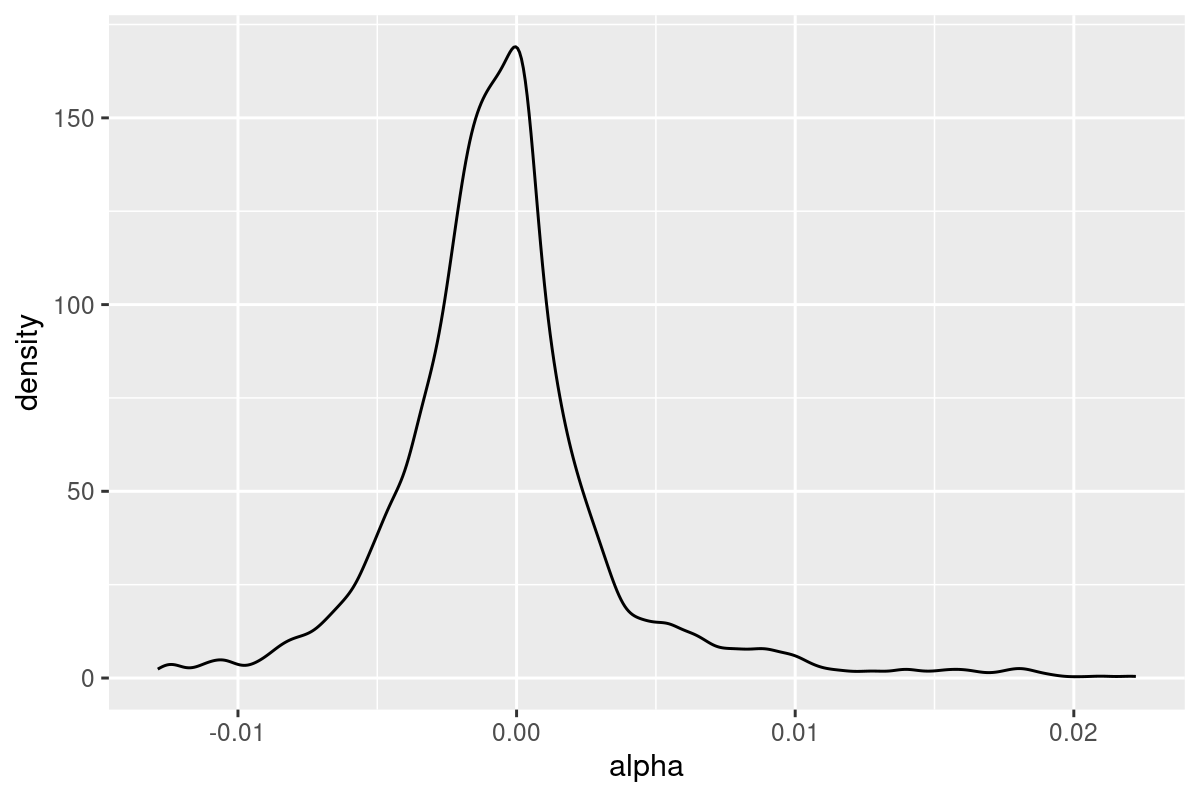

In [185]:
alpha_beta = data[,
    # Step 1: calculate the daily market return
    ':='(mkt_ret=weighted.mean(retx, cap, na.rm=T)),
    keyby=.(date)
    ][,
    # Step 2: get the \alpha and \beta
    {
        lm_out = lm(retx ~ mkt_ret)
        alpha = coef(lm_out)[1]
        beta = coef(lm_out)[2]
        list(alpha=alpha, beta=beta)
    },
    keyby=.(permno)
    ][
    # step 3: remove extreme values
    alpha %between% c(quantile(alpha, 0.02), quantile(alpha, 0.98))]

alpha_beta[1:3]

alpha_beta[, 
    # Step 4: calculate the statistics of alpha and beta
    .(alpha=mean(alpha, na.rm=T), beta=mean(beta, na.rm=T),
      sd_alpha=sd(alpha, na.rm=T), sd_beta=sd(beta, na.rm=T))
    ]

library(ggplot2)

# Step 5: plot the distribution of alpha and beta
alpha_beta %>% 
    ggplot(aes(x=alpha)) +
    geom_density()

alpha_beta %>% 
    ggplot(aes(x=beta)) +
    geom_density()

**Execution Explained:**

- Step 1: calculate the daily market return.

- Step 2: calculate the alphas and betas. The technique is introduced in [this problem](lm-in-j).

- Step 3: we remove extreme values beyond the 2% and 98% percentiles. We do this to make the following visualization more clear. In real world you may not want to this.

- Step 4: calculate the statistics of alpha and beta.

- Step 5: plot the density of alphas and betas using `ggplot2`. This is the first time we use visualization in this chapter. A quick start of `ggplot2` can be found [here](http://www.sthda.com/english/wiki/ggplot2-barplots-quick-start-guide-r-software-and-data-visualization).

## ⭐️ Find out the stocks whose abnormal returns rank top 100 for all of the previous three days

**Problem Explained:**

This problem is a combinition of [problem "calculate the daily abnormal return"](lm-in-j) and [prolbem "find out stocks that outperform the market in the past three days"](past-three-days). It requires us to:

- First, compute the daily abnormal return for each stock.

- Second, find out stocks whose abnormal return rank top 100 in each of the past three days.

Since you've already learned all the necessary techniques. Try it before continuing to read!

In [186]:
# Section 1: calculate daily abnormal return

daily_abnormal_return = data[,
    ':='(ret_mkt=weighted.mean(retx, cap, na.rm=T)), keyby=.(date)
    ][, .SD[.N>=50], keyby=.(permno)
    ][!is.na(retx)
    ][, {
        lm_out = lm(retx ~ ret_mkt)
        ar = resid(lm_out)
        list(date, ar)
    },
    keyby=.(permno)]

daily_abnormal_return[1:3]

permno date       ar          
1 10026  2023-01-03  0.012975042
2 10026  2023-01-04 -0.004386641
3 10026  2023-01-05 -0.007474872

**Execution Explained:**

Calculate the daily abnormal return for each stock. See [this problem](lm-in-j) for details.

In [187]:
# Section 2: find out stocks whose abnormal return rank top 100 for all of the past three days

daily_abnormal_return[
    # Step 1: find out the stocks whose abnormal return ranks top 100 on each day
    order(date, -ar), .(permno_list=list(permno[1:100])), keyby=.(date)
    ][, 
    # Step 2: compute the number of stocks that meet the criteria
    {
    num_stk_3d = vector()  # store the number of stocks on each day
    stk_list_3d = list()  # store the list of stocks on each day

    for (i in 4:.N) {
        # `stks` is the list of stocks that meet the criteria on each day
        stks = Reduce(intersect, permno_list[(i-3):(i-1)])

        stk_list_3d[[i]] = stks  # don't use "[i]", you must use "[[i]]"
        num_stk_3d[i] = length(stks)
    }
    list(date, num_stk_3d, stk_list_3d)
    }
    ][!is.na(num_stk_3d)
    ][1:3]

date       num_stk_3d stk_list_3d                             
1 2023-01-06 6          19969, 89411, 16178, 16303, 22797, 15059
2 2023-01-09 2          88626, 17906                            
3 2023-01-10 3          21089, 15779, 17906

**Execution Explained:**

The main part of the code is very similar to [this problem](past-three-days). I only highlight some differences:

- Step 1: We first sort by `permno` and `date`, then we group by `permno`. As a result, the first 100 rows in each group will have the largest abnormal return (`list(permno[1:100])`).

- Step 2: In this problem, I not only want to count the number of stocks that meet our criteria, but also want to return the `permno` of these stocks. To this end, I created two variables, `num_stk_3d` and `stk_list_3d`, to store them separately.

## ⭐️ Final Exam: Find out the stocks whose abnormal returns rank top 30% in the industry in all of the previous three days

**Problem Explained:**

This is the final exam, try to solve it as a test of your learning outcome!

This problem requires us to:

- First, calculate the daily abnormal return of each stock.

- Second, find out the stocks whose abnormal return rank top 30% in its industry in all of the previous three days.

In [188]:
# Section 1: calculate daily abnormal return

daily_abnormal_return = data[,
    ':='(ret_mkt=weighted.mean(retx, cap, na.rm=T)), keyby=.(date)
    ][, .SD[.N>=50], keyby=.(permno)
    ][!is.na(retx)
    ][, {
        lm_out = lm(retx ~ ret_mkt)
        ar = resid(lm_out)
        list(date, ar, industry=industry[1])
    },
    keyby=.(permno)]


# Section 2: find out stocks whose abnormal return rank top 100 for all of the past three days

daily_abnormal_return[
    # Step 1: find out the stocks whose abnormal return ranks top 30% in the industry on each day
    order(date, industry, -ar), .(permno_list=list(permno[1:(0.3*.N)])), keyby=.(date, industry)
    ][,
    # Step 2: (important!) unpack and repack the permno list by date
    .(permno_list=list(unlist(permno_list))), keyby=.(date)
    ][, 
    # Step 3: compute the number of stocks that meet the criteria
    {
    num_stk_3d = vector()  # store the number of stocks on each day
    stk_list_3d = list()  # store the list of stocks on each day

    for (i in 4:.N) {
        # `stks` is the list of stocks that meet the criteria on each day
        stks = Reduce(intersect, permno_list[(i-3):(i-1)])

        stk_list_3d[[i]] = stks  # don't use "[i]", you must use "[[i]]"
        num_stk_3d[i] = length(stks)
    }
    list(date, num_stk_3d, stk_list_3d)
    }
    ][!is.na(num_stk_3d)
    ][1:3]

date       num_stk_3d
1 2023-01-06 172       
2 2023-01-09 111       
3 2023-01-10 100       
  stk_list_3d                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       
1 16981, 85726, 16019, 77902, 23297, 65752, 24459, 93423, 14045, 20848, 77300, 13168, 19813, 89167, 17875, 89002, 93434, 13860, 16802, 14317, 14716, 76279, 79909, 92089, 19920, 90164, 20338, 21286, 12448, 20115, 19859, 21598, 80960, 66157, 15580, 17369, 91413, 16880, 20178, 18086, 64995, 22618, 71563, 21277, 58246, 15064, 23473, 14574, 59408, 79851, 16964, 18043, 79323, 21361, 81593, 18802, 18838, 18783, 88284, 34666, 82281, 88372, 16049, 63773, 14490, 16975, 75320, 22092, 18134, 16697, 26403, 15087, 81696, 78664, 20447, 14889, 19969, 89411, 19559, 16178, 16303, 19621, 22797, 80759, 92594, 18089, 15059, 77202, 14543, 16773, 92486, 91416, 72304, 78908, 77437, 18664, 13410, 19993, 22312, 77496, 91471, 14185, 17906, 88626, 22240, 85072, 17977, 20207, 13328, 83651, 93004, 88332, 14442, 90101, 15177, 19561, 91359, 20057, 22351, 91615, 19176, 84348, 19476, 27909, 22293, 15371, 25419, 14459, 92648, 93345, 90558, 13947, 92570, 43553, 88319, 89952, 82800, 22897, 22899, 81774, 76711, 21866, 18203, 17825, 19994, 21538, 13537, 15642, 22772, 23267, 18677, 89941, 78988, 21120, 91547, 18915, 20637, 20823, 89908, 67467, 12880, 14182, 20682, 18051, 15506, 16008, 19568, 82702, 20578, 31668, 78690, 13577
2 16981, 85726, 77902, 20545, 22255, 15273, 18514, 21608, 93434, 13860, 20338, 19002, 20115, 14229, 19920, 76136, 85860, 20464, 23473, 14574, 10933, 34746, 17357, 23477, 82775, 17880, 52936, 58246, 91413, 18043, 91176, 14127, 34666, 18415, 81761, 92528, 88372, 16049, 22092, 16697, 65875, 13757, 14811, 88626, 16924, 14937, 16773, 17906, 23269, 14823, 89411, 19621, 19559, 88332, 11654, 15177, 20288, 20207, 83462, 17358, 21750, 90520, 52396, 78908, 13936, 14536, 19993, 90558, 86778, 66384, 17139, 88597, 19561, 79586, 34817, 21072, 17372, 80759, 11275, 91606, 14543, 17281, 20581, 41188, 22897, 16689, 89952, 81774, 82800, 23273, 13537, 19313, 17885, 20292, 21538, 15057, 23267, 21866, 91547, 19555, 77515, 19494, 67467, 20682, 20823, 16008, 23056, 78690, 17105, 19142, 16084                                                                                                                                                                                                                                                                                                                                                                                                                                           
3 85726, 16981, 77902, 20545, 75034, 21608, 19880, 18058, 22255, 15273, 21685, 17361, 91498, 20452, 90454, 14574, 20115, 76136, 69649, 91413, 89443, 16548, 17151, 82486, 19002, 14229, 23477, 20451, 23014, 20464, 15072, 16697, 87356, 16049, 34948, 23505, 22280, 17358, 22244, 21750, 15779, 17